In [1]:
import os
import matplotlib.pyplot as plt
import re

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

from scipy.optimize import curve_fit
import scipy.ndimage as ndimage

In [2]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [3]:
# Butler
import lsst.daf.butler as dafButler
from lsst.daf.butler import CollectionType
#from lsst.daf.butler import CollectionTypes

In [4]:
embargo = True

In [5]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"  # /repo/embargo
else:
    repo = "/sdf/group/rubin/repo/main" # repo/main
butler = dafButler.Butler(repo)
registry = butler.registry

In [6]:
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)
#calibCollections = ...

In [7]:
#exposure_selected=2023021400848
flat_date = 20230116
flats_selected = [2023011600015, 2023011600014, 2023011600016]

## Select flat 

In [8]:
flat_selected = 2023011600015

In [9]:
#outdir = './special_flats_{0}/'.format(exposure_selected)
outdir_base = './special_flats/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_ = os.path.join(outdir_base,str(flat_date))
if os.path.exists(outdir_)==False:
    os.mkdir(outdir_)
outdir = os.path.join(outdir_,str(flat_selected))
if os.path.exists(outdir)==False:
    os.mkdir(outdir)
print(outdir)

./special_flats/20230116/2023011600015


In [10]:
flat_img = butler.get("flat", instrument="LATISS", exposure=flat_selected, detector=0, collections=calibCollections)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: UserWarning: Reading file:///tmp/tmp9lcja5bj.fits with data ID {instrument: 'LATISS', detector: 0, physical_filter: 'empty~empty', ...}: filter label mismatch (file is None, data ID is FilterLabel(band="white", physical="empty~empty")).  This is probably a bug in the code that produced it.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
flat_array = flat_img.getImage().array

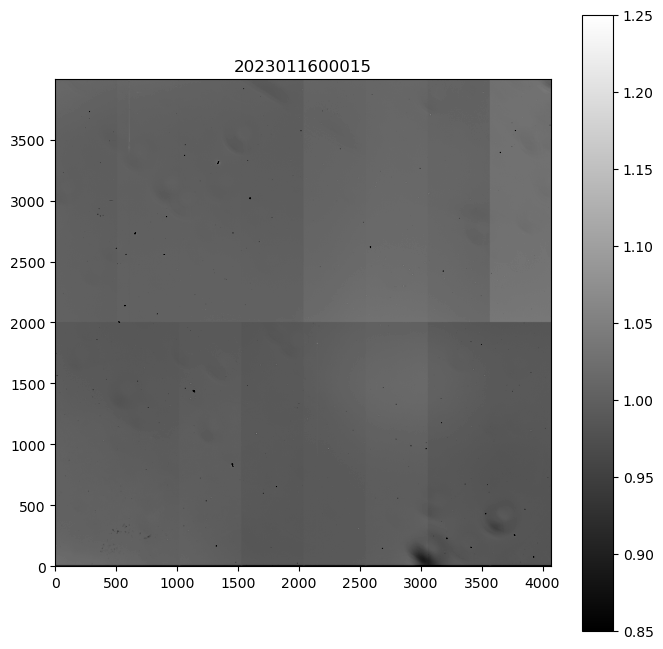

In [12]:
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
im = ax.imshow(flat_array,cmap="gray",vmin=0.85,vmax=1.25,origin='lower')#,norm=LogNorm())
ax.set_title(flat_selected)
fig.colorbar(im,ax=ax)

## We extract the data and metadata from the image 

In [13]:
md = flat_img.getMetadata().toDict()
filter_ = md['FILTER']
print(filter_)

empty_1


In [14]:
all_img = []
all_nameimg = []
all_boximg = {}

for ampIdx, amp in enumerate(flat_img.getDetector()):
    ampName = amp.getName()
    all_nameimg.append(ampName)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    all_boximg[ampName] = (xbegin,xend,ybegin,yend)
    
    # This can work only on postISRCCD
    ampExp = flat_img.Factory(flat_img, amp.getBBox())
    amp_img = ampExp.getImage().array
    all_img.append(amp_img) 
   

In [15]:
all_boximg

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

## We organise the amplifiers separately 

We will work like this except to compute the smooth component, which we compute on the full image to preserve changes between amplifiers (see next point) 

In [16]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [17]:
num_amplis = len(mapampid)

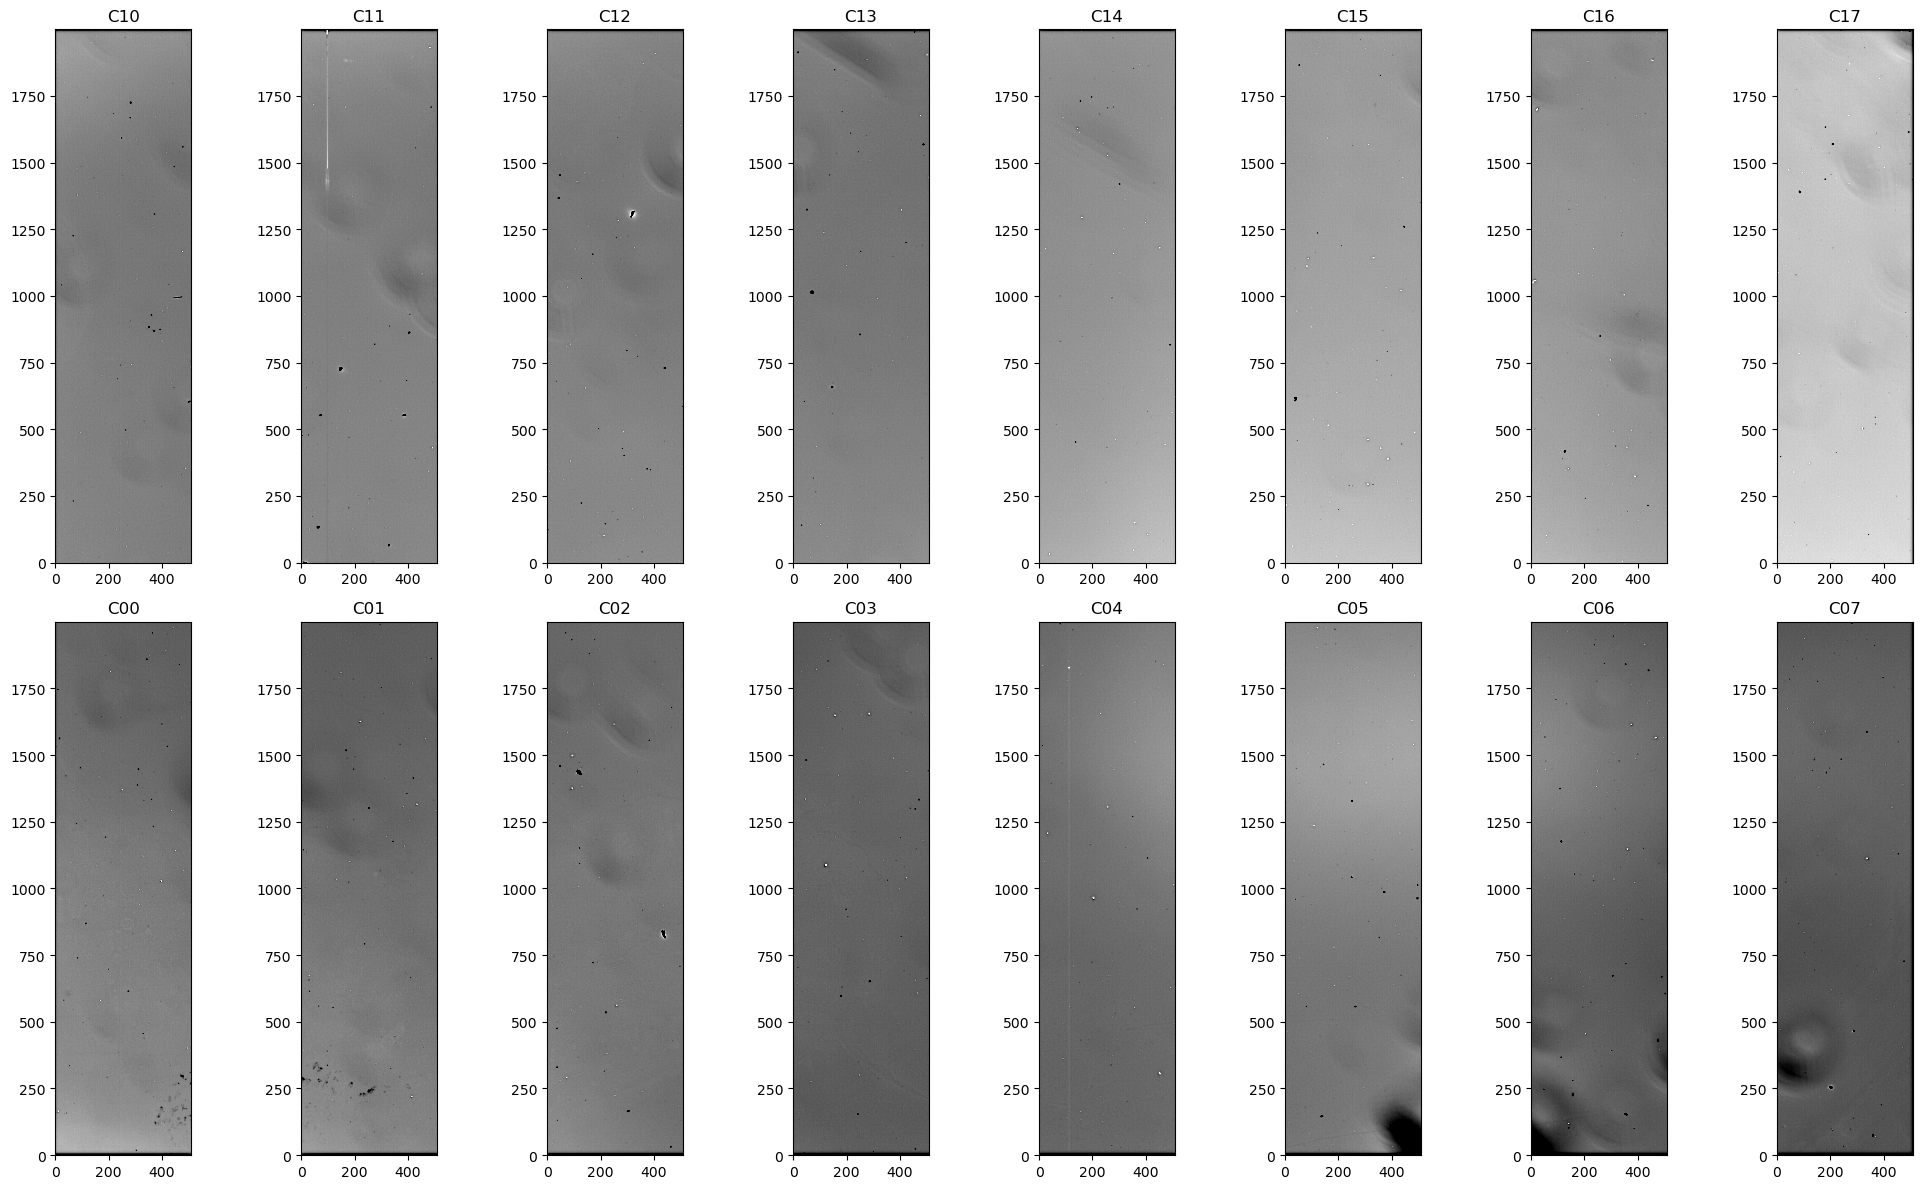

In [18]:
fig=plt.figure(figsize=(20,12))

for idx in range(num_amplis):
    #print(mapampid[idx]+1)
    ax=fig.add_subplot(2,8,mapampid[idx]+1)
    ax.imshow(all_img[idx],origin='lower',vmin=0.95,vmax=1.05,cmap="gray")
    ax.set_title(all_nameimg[idx])
plt.tight_layout()

# Make special flat 

## First, we normalise the each amplifier by its median so we put them at the same level 

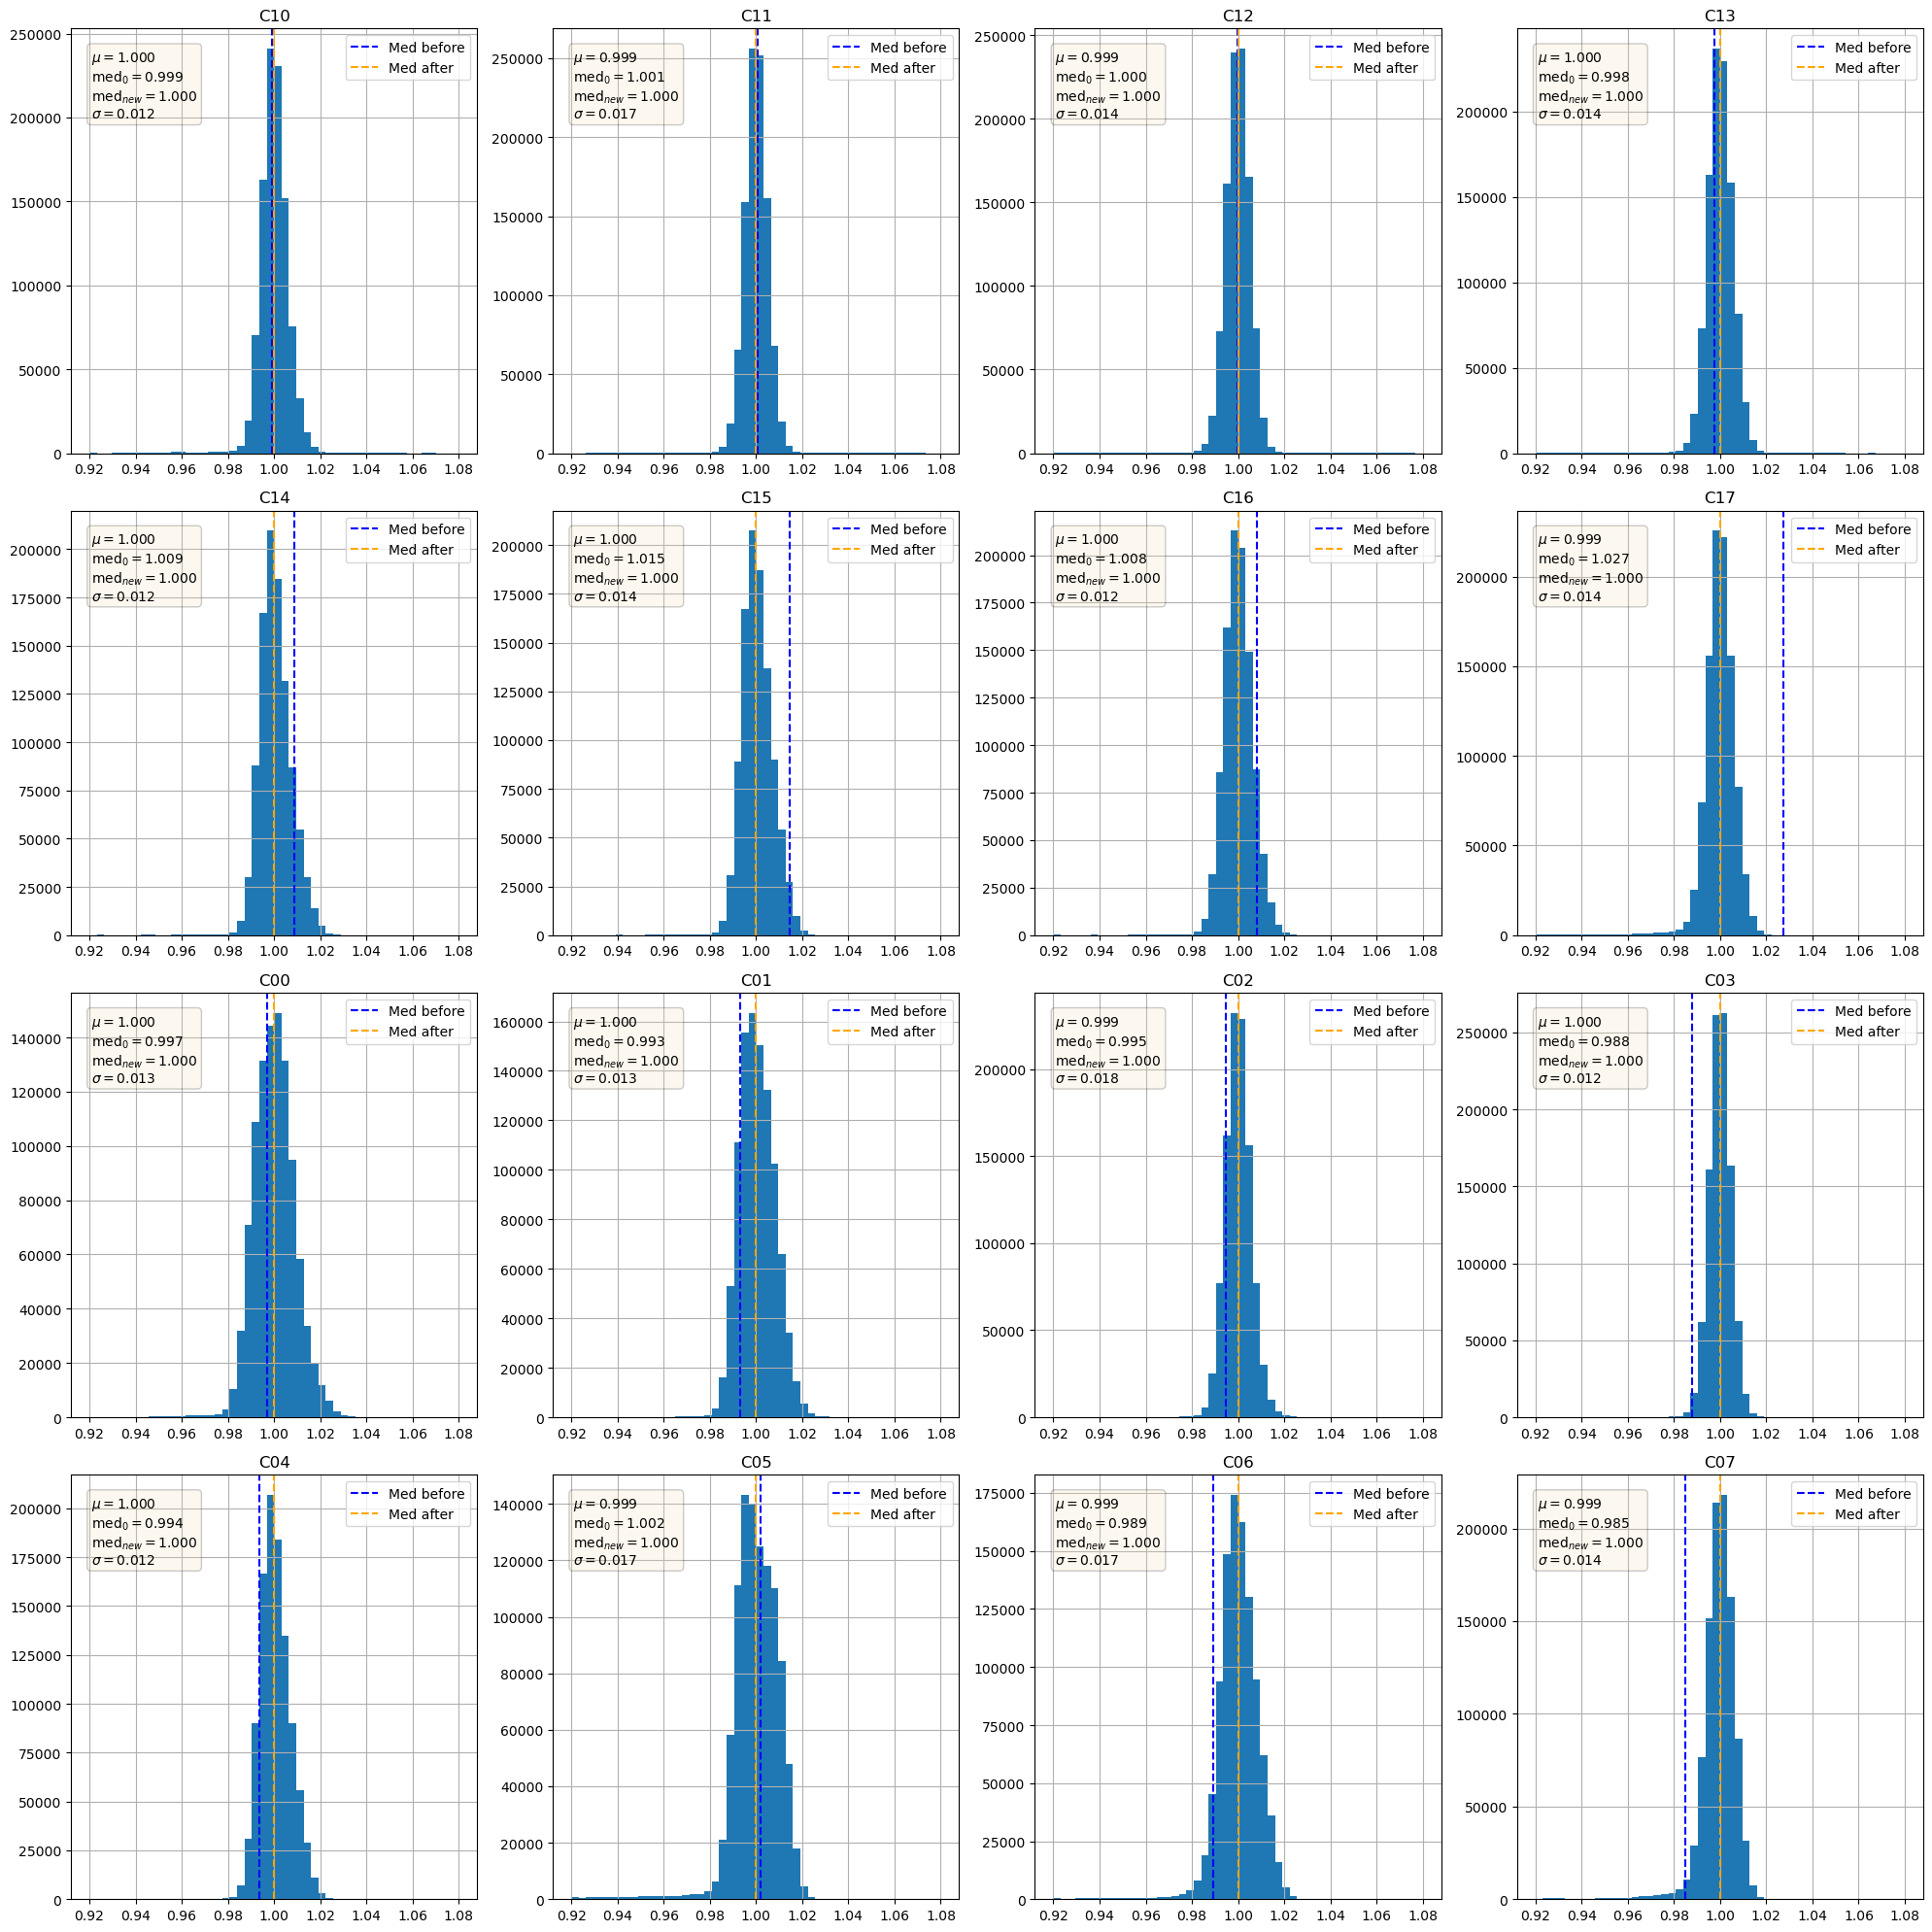

In [19]:
fig=plt.figure(figsize=(20,20))

for idx in range(num_amplis):
    ax=fig.add_subplot(4,4,mapampid[idx]+1)
    
    data_ = all_img[idx].flatten()
    data_median_ = np.median(data_)
    data_ = data_/data_median_
    
    ax.hist(data_,bins=50,range=(0.92,1.08))

    mu = data_.mean()
    median_after = np.median(data_)
    sigma = data_.std()
    textstr = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\mathrm{med}_{0}=%.3f$' % (data_median_, ),
    r'$\mathrm{med}_{new}=%.3f$' % (median_after, ),
    r'$\sigma=%.3f$' % (sigma, )))
    
    ax.axvline(x=data_median_,ls='--',color='b',label='Med before')
    ax.axvline(x=median_after,ls='--',color='orange',label='Med after')
    #ax.set_yscale("log")
    ax.grid()
    ax.set_title(all_nameimg[idx])
    ax.legend(loc="upper right")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
 
plt.tight_layout()

In [20]:
load_norm_flat = True
remove_gradient = False

In [21]:
if load_norm_flat:
    #norm_array = np.load(os.path.join(outdir,'ccd_median_normalised_flat.npy'))
    norm_file = fits.open(os.path.join(outdir,'ws_analysis/ccd_median_normalised_flat_{0}_{1}.fits'.format(flat_selected,filter_)))
    norm_array = norm_file[1].data
    
else:
    for iampli in mapampid:
        #iampli = mapampid[idx]
        iampli_name = all_nameimg[iampli]
        print(iampli,iampli_name)
        
        amp_data = np.copy(all_img[iampli])
        amp_median = np.median(all_img[iampli].flatten())
        amp_norm_ = amp_data/amp_median
        #amp_norm = np.zeros((amp_norm_.shape[0],amp_norm_.shape[1]))
        
        #col1_norm = ampli0_norm[5:,column1]
        if remove_gradient:
            amp_norm = np.zeros((amp_norm_.shape[0],amp_norm_.shape[1]))
            for icolumn in range(amp_norm_.shape[1]):
                coli_norm = amp_norm_[:,icolumn]
                vec_median_i = []
                for i in np.arange(0,len(coli_norm),delta_pix):
                    vec_median_i.append(np.median(coli_norm[i:i+delta_pix]))
                vec_median_i = np.array(vec_median_i)

                vec_med_i = np.median(vec_median_i)
                vec_std_i = np.std(vec_median_i)

                sigma_mask_i = (vec_median_i>=vec_med_i-sigma_fit*vec_std_i)*(vec_median_i<=vec_med_i+sigma_fit*vec_std_i)

                xi_fit = np.arange(len(vec_median_i))[sigma_mask_i]
                vec_median_i_fit = vec_median_i[sigma_mask_i]

                parami,covi = curve_fit(grad_model,xi_fit,vec_median_i_fit)

                xi_ = np.arange(len(coli_norm))
                modeli = grad_model(xi_,parami[0],parami[1])

                amp_norm[:,icolumn] = coli_norm/modeli
        
        else:
            amp_norm = amp_norm_
        
        if iampli<=7:
            if iampli==0:
                data_up = amp_norm
            else:
                data_up = np.concatenate((data_up,amp_norm),axis=1)
        else:
            if iampli==15:
                data_down = amp_norm
            else:
                data_down = np.concatenate((data_down,amp_norm),axis=1)
    norm_array = np.concatenate((data_down,data_up),axis=0)
    #np.save(os.path.join(outdir,'ccd_median_normalised_flat.npy'),norm_array)
    
    
    hdr = fits.Header()
    
    for key,value in md.items():
        hdr[str(key)] = value
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(norm_array)
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    
    hdu_list.writeto(os.path.join(outdir,'ccd_median_normalised_flat_{0}_{1}.fits'.format(flat_selected,filter_)),overwrite=True)
    
    

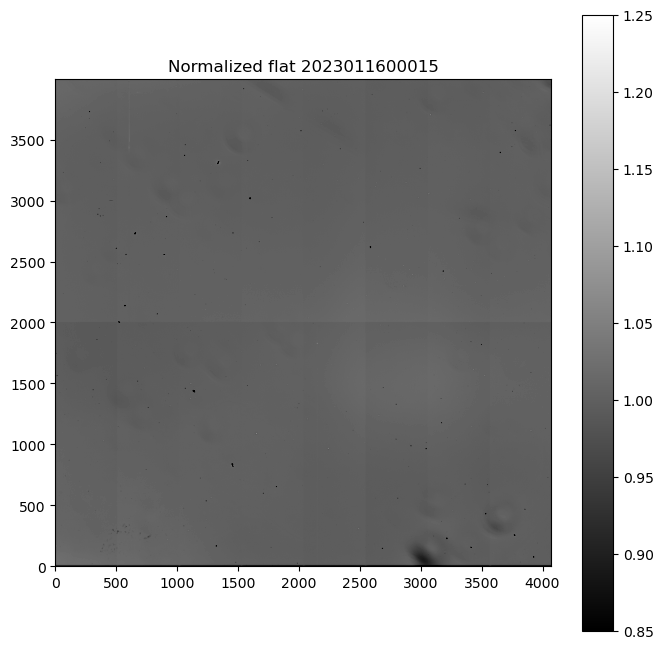

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(norm_array,cmap="gray",vmin=0.85,vmax=1.25,origin='lower')#,norm=LogNorm())
ax.set_title('Normalized flat {0}'.format(flat_selected))
plt.colorbar(im,ax=ax)

## Now we apply the smoothing on the normalised (and detrended) flat 

In [23]:
window_sizes = np.array([2,5,10,20,30,40,50]) #From 03_make_smoothing_window_size_analysis.ipynb 

window_size = 40
load_smooths = True

In [24]:
if load_smooths:
    smooth_list_ws = np.load(os.path.join(outdir,'ws_analysis/ccd_smoothed_flat_{0}_{1}.npy'.format(flat_selected,filter_)))[0]
    
    ws_index = np.where(window_sizes==window_size)[0][0]
    
    smooth_data = smooth_list_ws[ws_index]
    
else:
    smooth_data = ndimage.median_filter(norm_array,size=window_size)
    

We store the smoothed image separately for each amplifier: 

In [25]:
smooth_list = []
for ampli_name_ in all_nameimg:
    print(ampli_name_)
    
    x0_ = all_boximg[ampli_name_][0]
    x1_ = all_boximg[ampli_name_][1]
    y0_ = all_boximg[ampli_name_][2]
    y1_ = all_boximg[ampli_name_][3]
    
    smooth_i_ = smooth_data[y0_:y1_,x0_:x1_]
    smooth_list.append(smooth_i_)
    

C10
C11
C12
C13
C14
C15
C16
C17
C07
C06
C05
C04
C03
C02
C01
C00


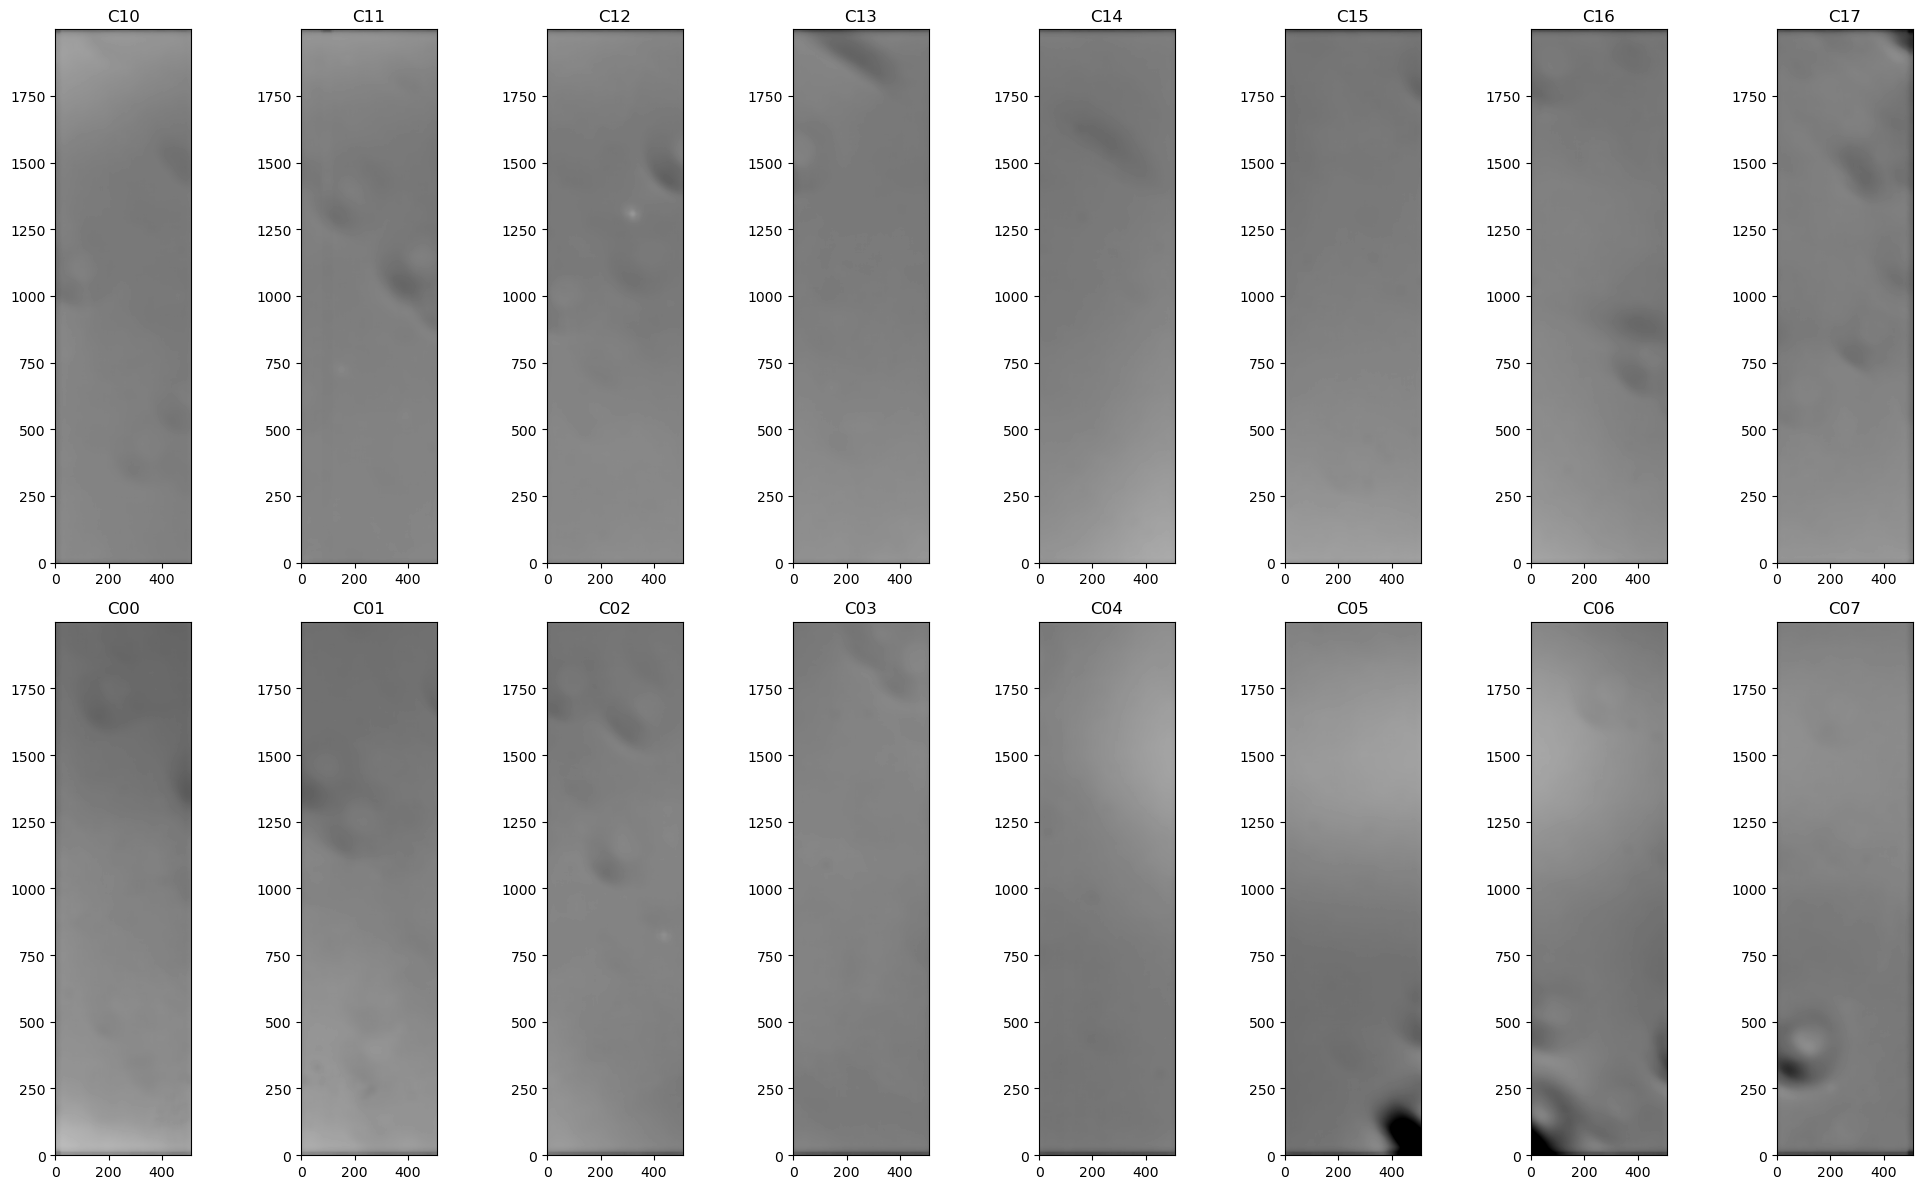

In [26]:
fig=plt.figure(figsize=(20,12))
for idx in range(num_amplis):
    
    ax=fig.add_subplot(2,8,mapampid[idx]+1)
    ax.imshow(smooth_list[idx],origin='lower',vmin=0.95,vmax=1.05,cmap="gray")
    ax.set_title(all_nameimg[idx])
plt.tight_layout()

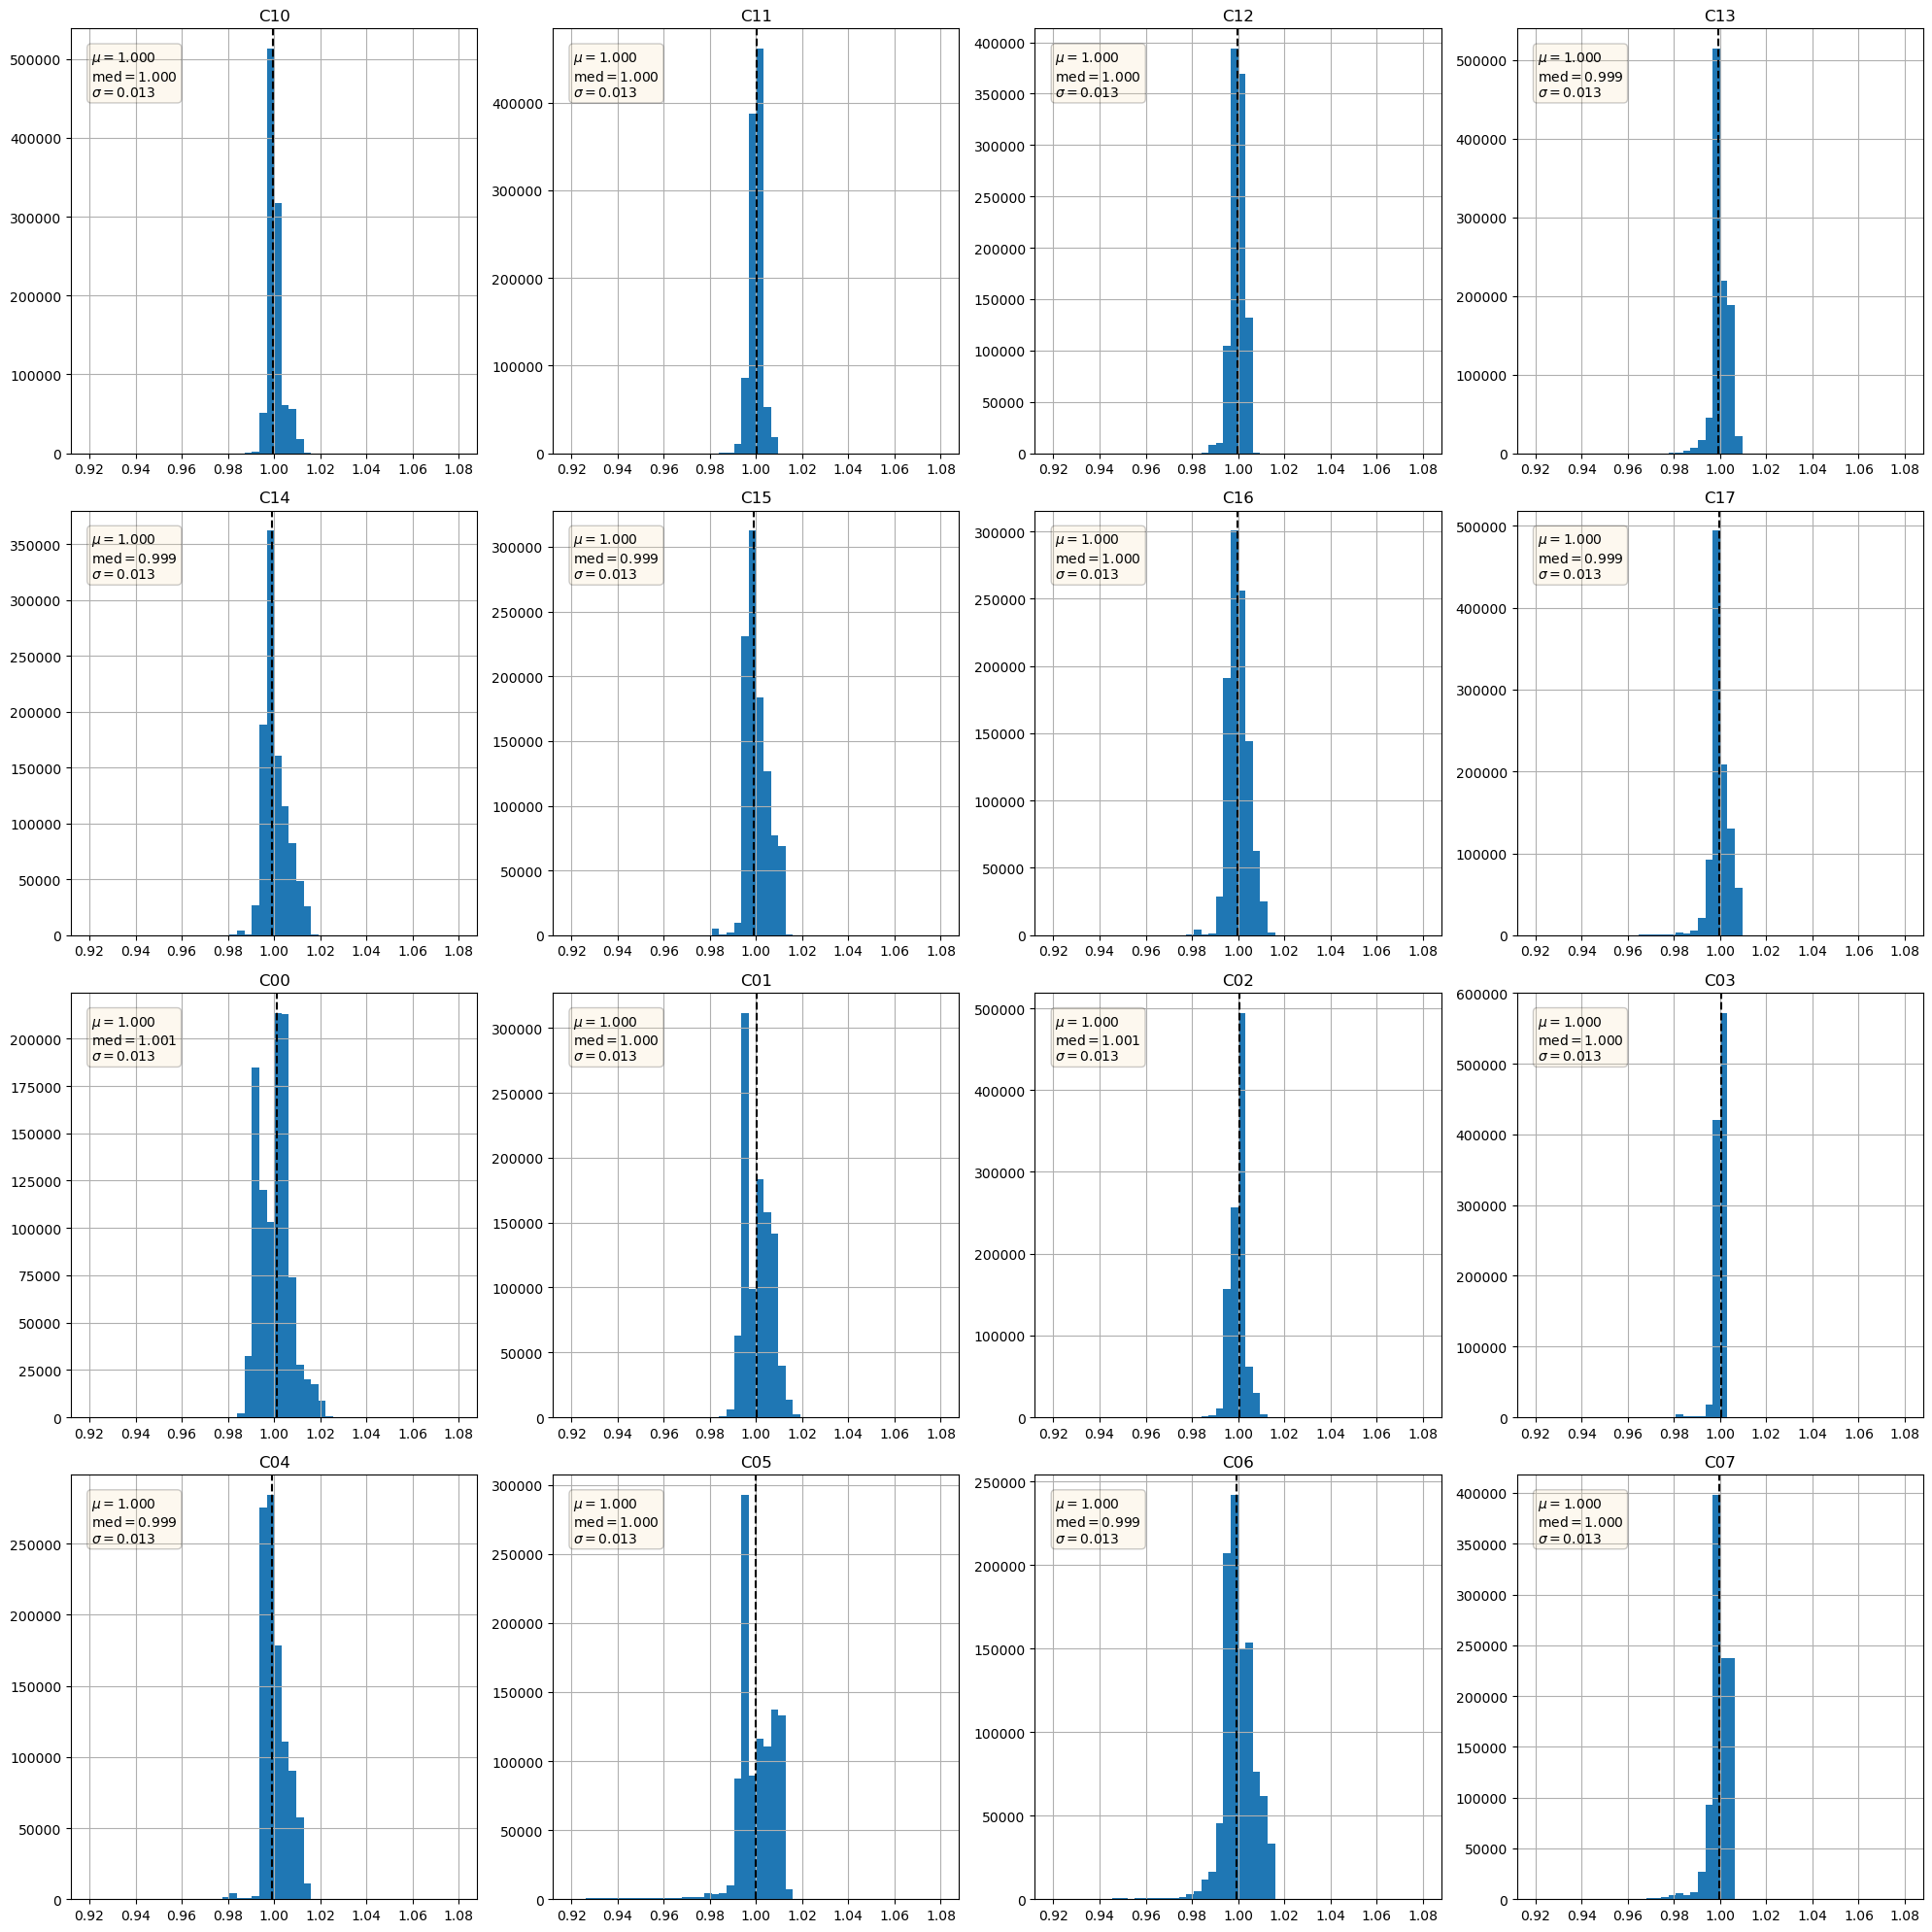

In [27]:
fig=plt.figure(figsize=(20,20))

for idx in range(num_amplis):
    ax=fig.add_subplot(4,4,mapampid[idx]+1)
    
    data_smooth_ = smooth_list[idx].flatten()
    amp_median_ = np.median(data_smooth_)
    
    ax.hist(data_smooth_,bins=50,range=(0.92,1.08),alpha=1.0)

    mu = data_.mean()
    sigma = data_.std()
    textstr = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\mathrm{med}=%.3f$' % (amp_median_, ),
    r'$\sigma=%.3f$' % (sigma, )))
    
    ax.axvline(x=amp_median_,ls='--',color='k')
    ax.grid()
    ax.set_title(all_nameimg[idx])  
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
plt.tight_layout()

# Create special flat 

Now we show the result of doing 

$$F_i^{\prime} = \frac{F_i}{S_i} \, ,$$

with $i$ running over the amplifiers. 

Since we have made the smoothing on the full image obtained after normalising each amplifier by its median, we DO NOT need to rescale the flat back to the original **global** median value by multiplying by it. 

NOTE: 

If we did not do this, then we would be dividing by the median smoothed images which preserve their own levels, so we would be approximately normalizing by the median, needing therefore to rescale it back to the original **global** median value by multiplying by it (all this is meant to be ampli by ampli). In reality, when dividing by the median smoothed images we would divide by a **spatially** dependent median, not the global one, so any slowly varying feature, such as a gradient, would be removed and it would not be recovered by simply multiplying by the original global median. We investigate this later. 

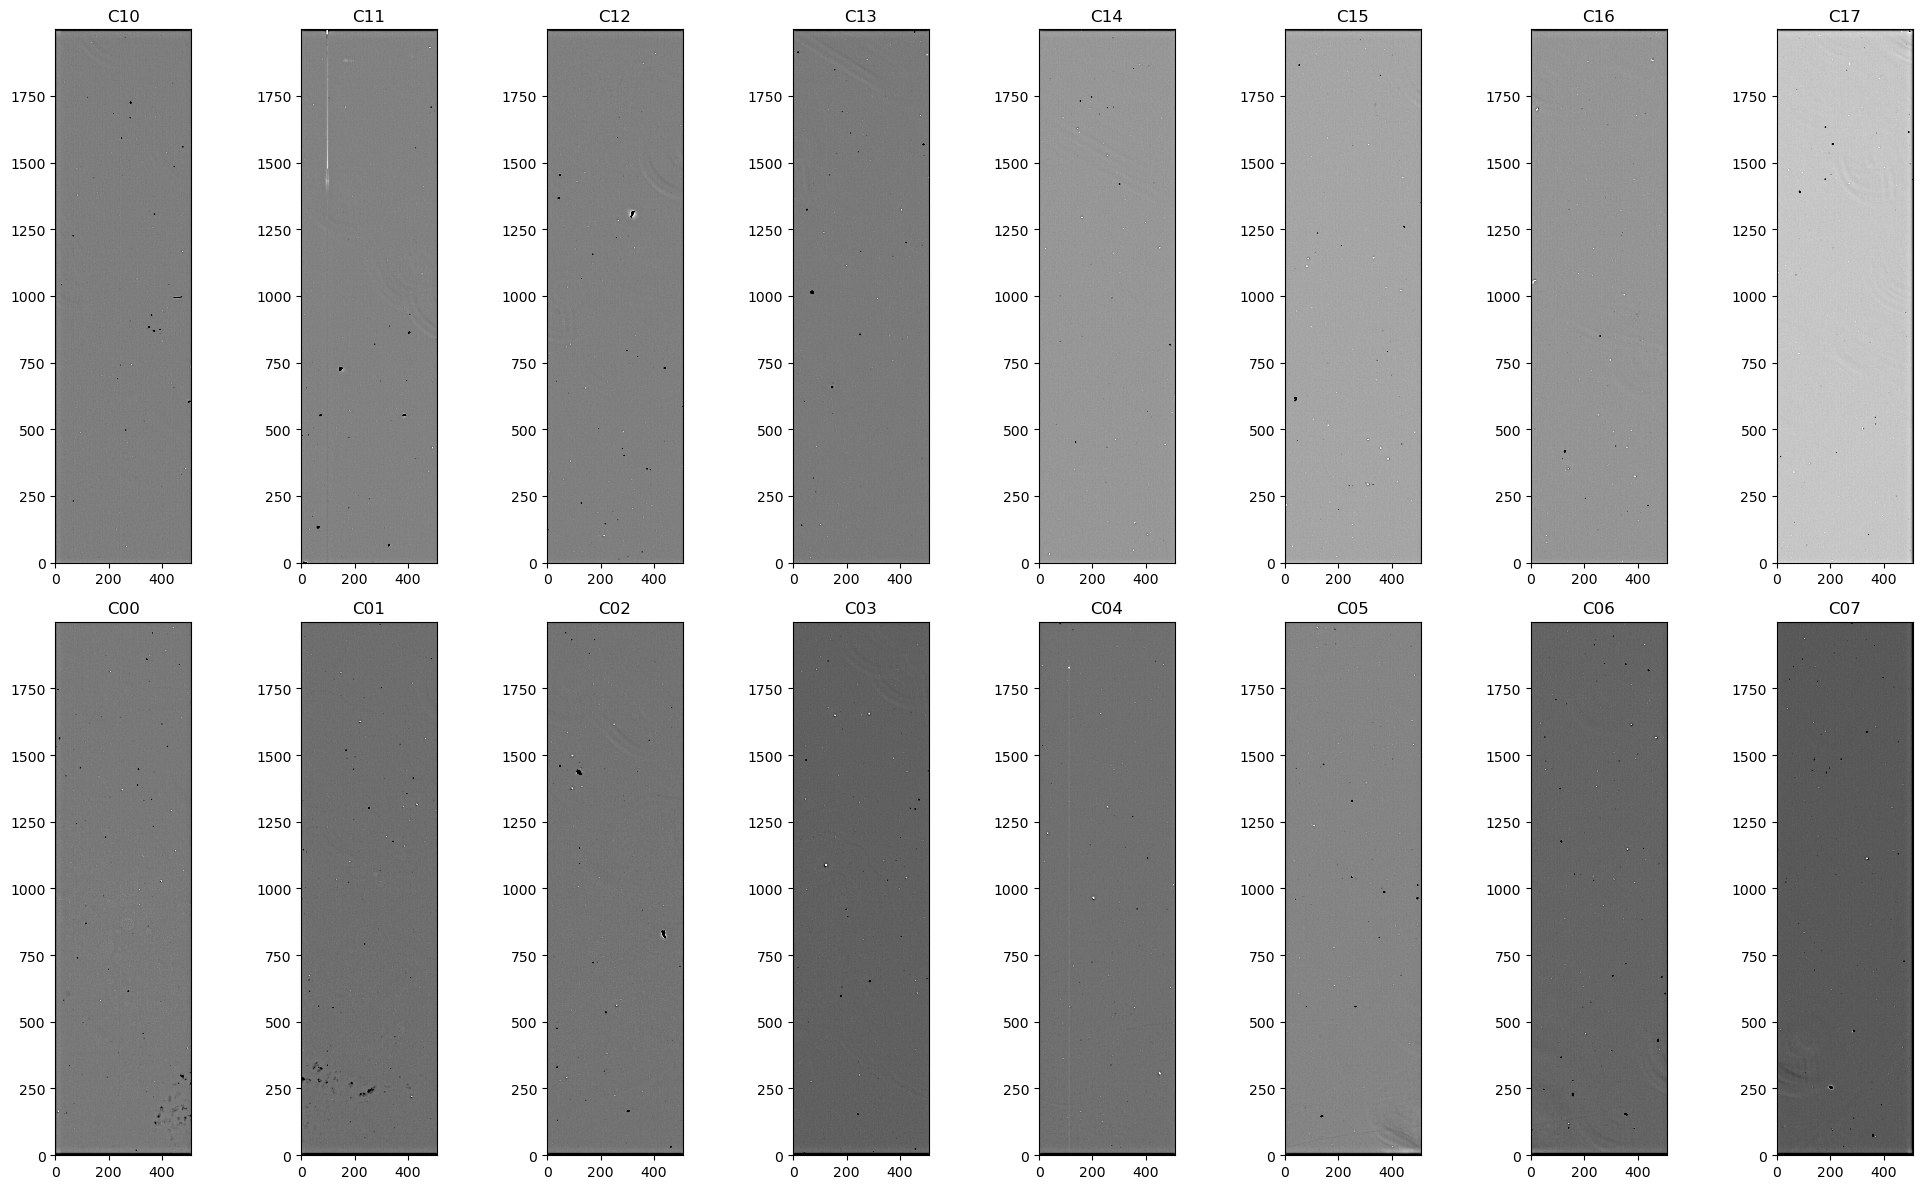

In [28]:
fig=plt.figure(figsize=(20,12))

for idx in range(num_amplis):
    ax=fig.add_subplot(2,8,mapampid[idx]+1)
    
    #amp_median = np.median(all_img[idx].flatten())
    
    ax.imshow(all_img[idx]/smooth_list[idx],origin='lower',vmin=0.95,vmax=1.05,cmap="gray")
    ax.set_title(all_nameimg[idx])
plt.tight_layout()

Let's see the distribution of the pixel values for each amplifier after removing the smooth components: 

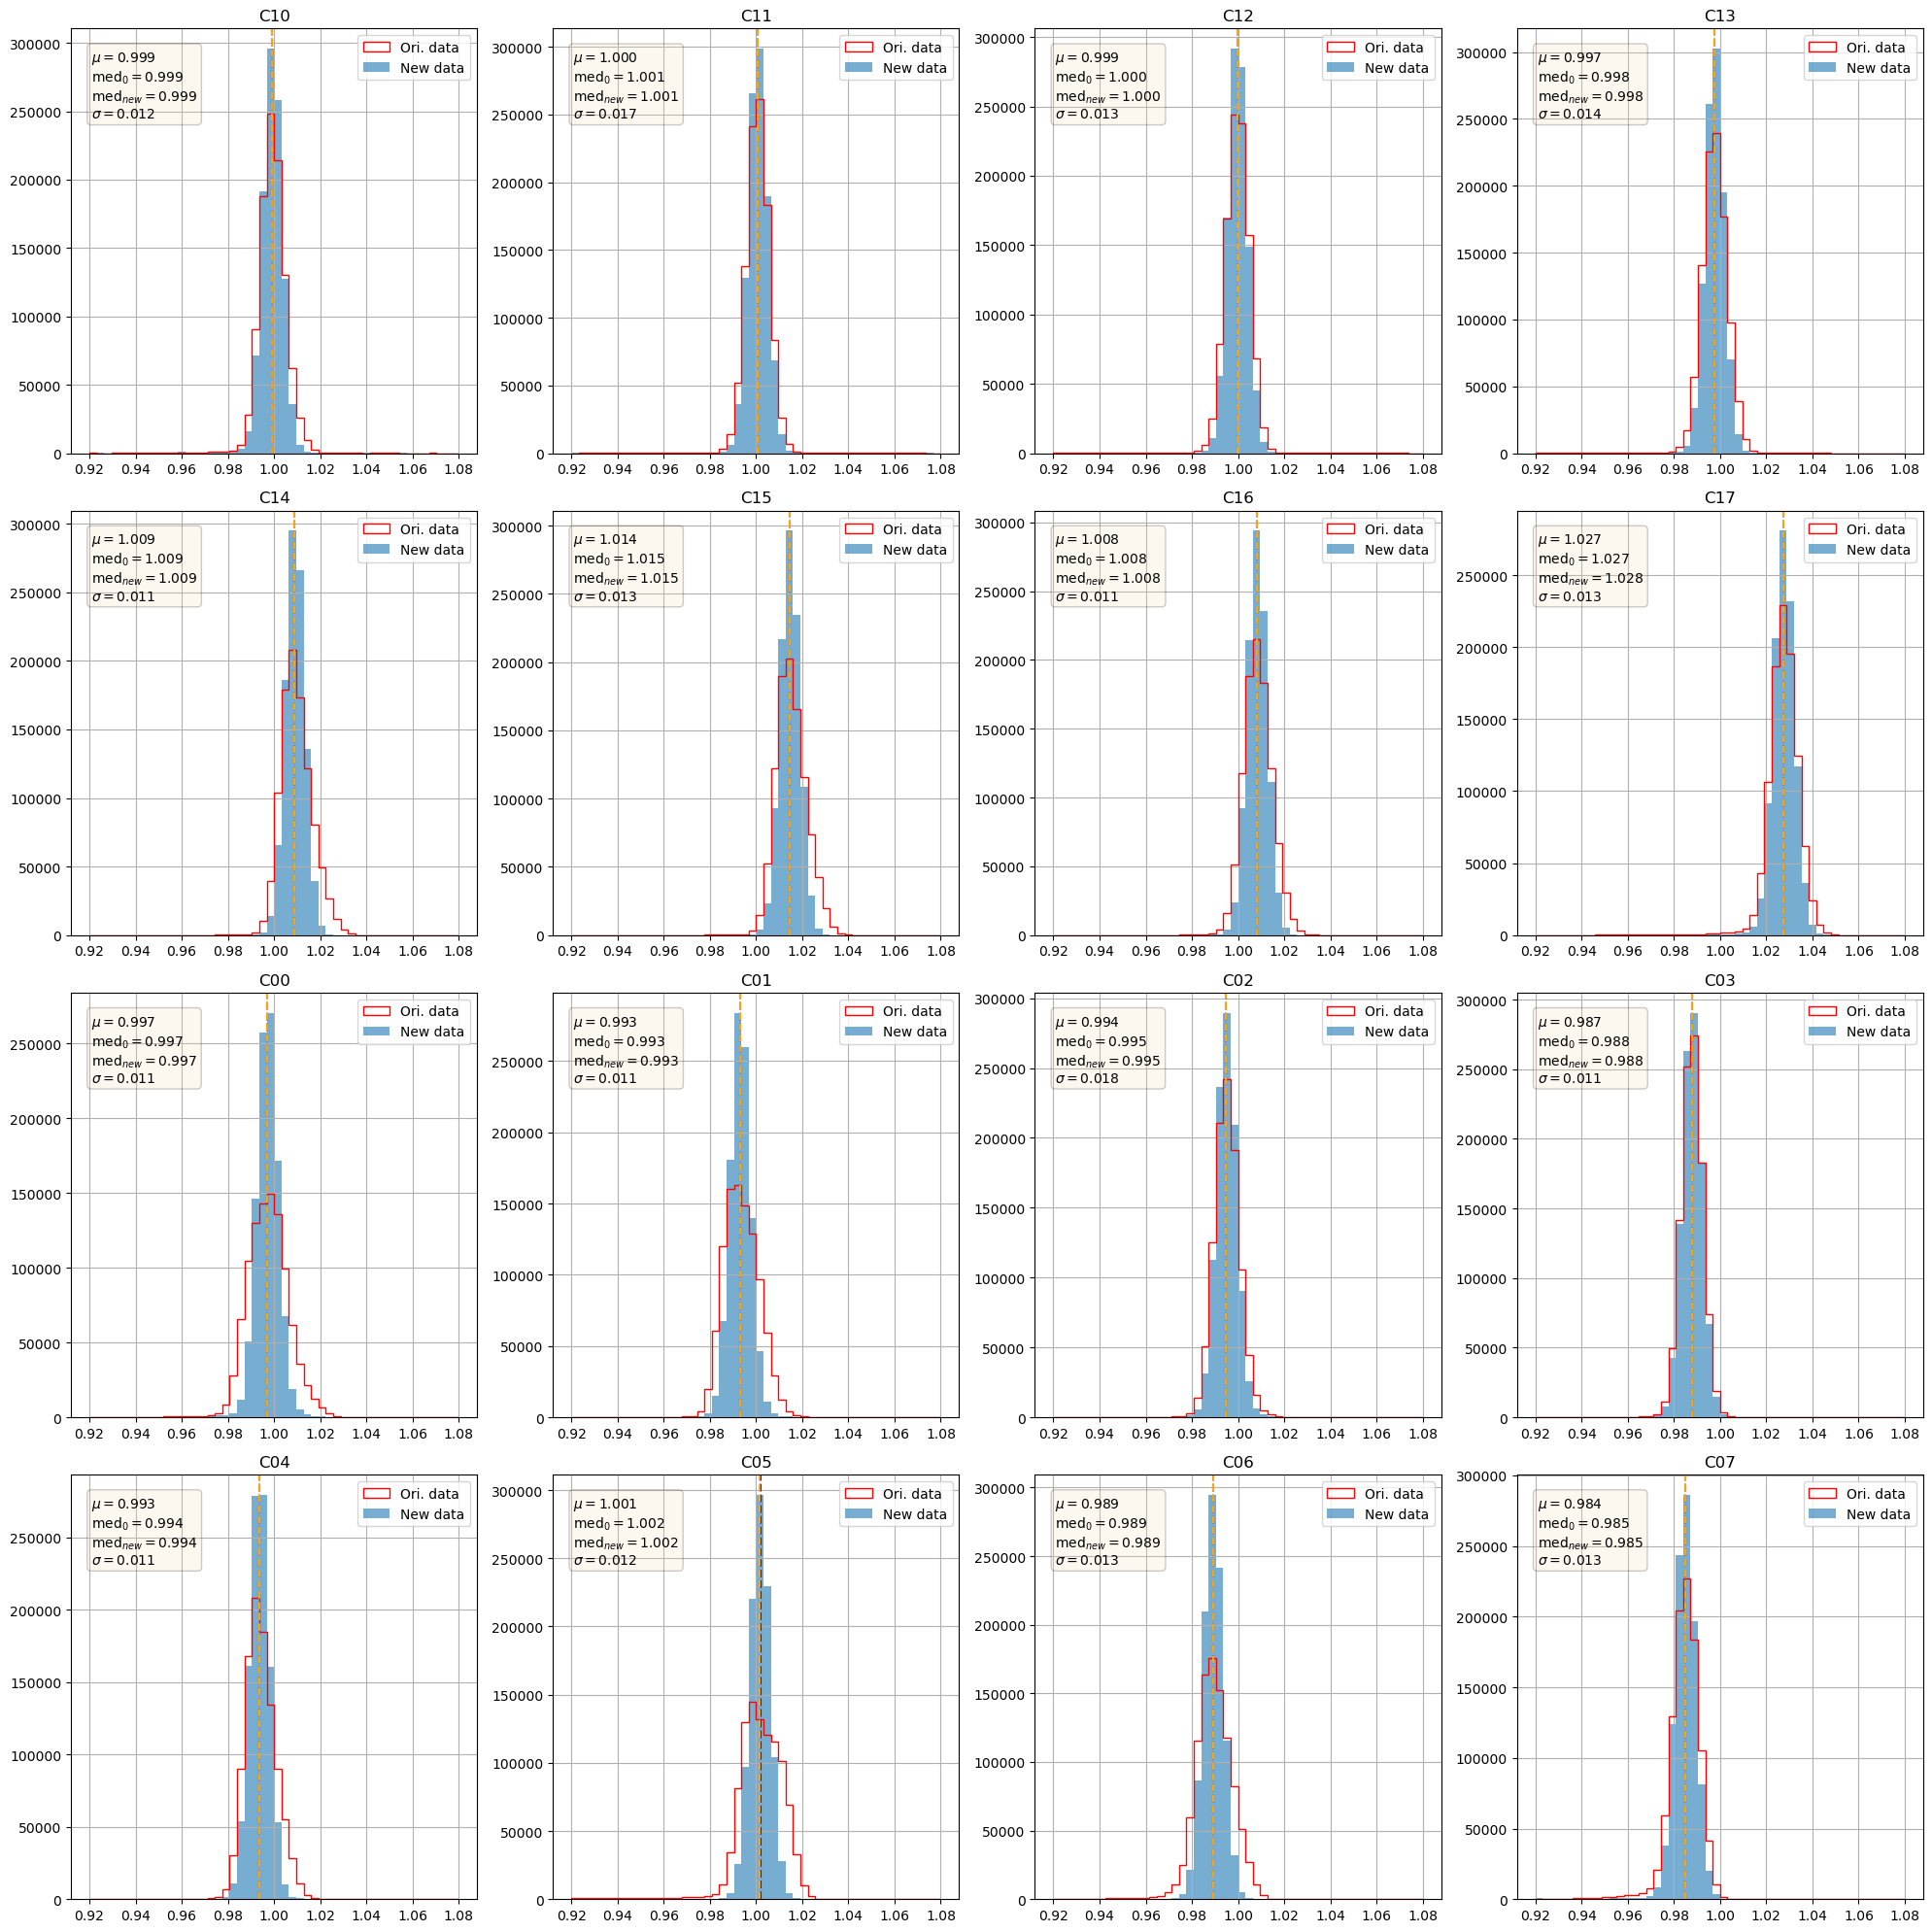

In [29]:
fig=plt.figure(figsize=(20,20))

for idx in range(num_amplis):
    ax=fig.add_subplot(4,4,mapampid[idx]+1)
    
    data0_ = all_img[idx].flatten()
    amp_median = np.median(data0_)
    
    data_ = all_img[idx].flatten()/smooth_list[idx].flatten()
    
    ax.hist(data0_,bins=50,range=(0.92,1.08),histtype='step',color='r',label='Ori. data')
    ax.hist(data_,bins=50,range=(0.92,1.08),alpha=0.6,label='New data')

    mu = data_.mean()
    median_after = np.median(data_)
    sigma = data_.std()
    textstr = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\mathrm{med}_{0}=%.3f$' % (amp_median, ),
    r'$\mathrm{med}_{new}=%.3f$' % (median_after, ),
    r'$\sigma=%.3f$' % (sigma, )))
    
    ax.axvline(x=amp_median,ls='--',color='b')
    ax.axvline(x=median_after,ls='--',color='orange')
    ax.grid()
    ax.set_title(all_nameimg[idx])
    ax.legend(loc="upper right")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
 
plt.tight_layout()

We store the special flat in an array 

In [30]:

for iampli in mapampid:
    iampli_name = all_nameimg[iampli]
    print(iampli,iampli_name)

    amp_data_ = np.copy(all_img[iampli])
    amp_smooth_ = np.copy(smooth_list[iampli])
    smooth_data_ = amp_data_/amp_smooth_

    if iampli<=7:
        if iampli==0:
            data_up = smooth_data_
        else:
            data_up = np.concatenate((data_up,smooth_data_),axis=1)
    else:
        if iampli==15:
            data_down = smooth_data_
        else:
            data_down = np.concatenate((data_down,smooth_data_),axis=1)
special_array = np.concatenate((data_down,data_up),axis=0)


0 C10
1 C11
2 C12
3 C13
4 C14
5 C15
6 C16
7 C17
15 C00
14 C01
13 C02
12 C03
11 C04
10 C05
9 C06
8 C07


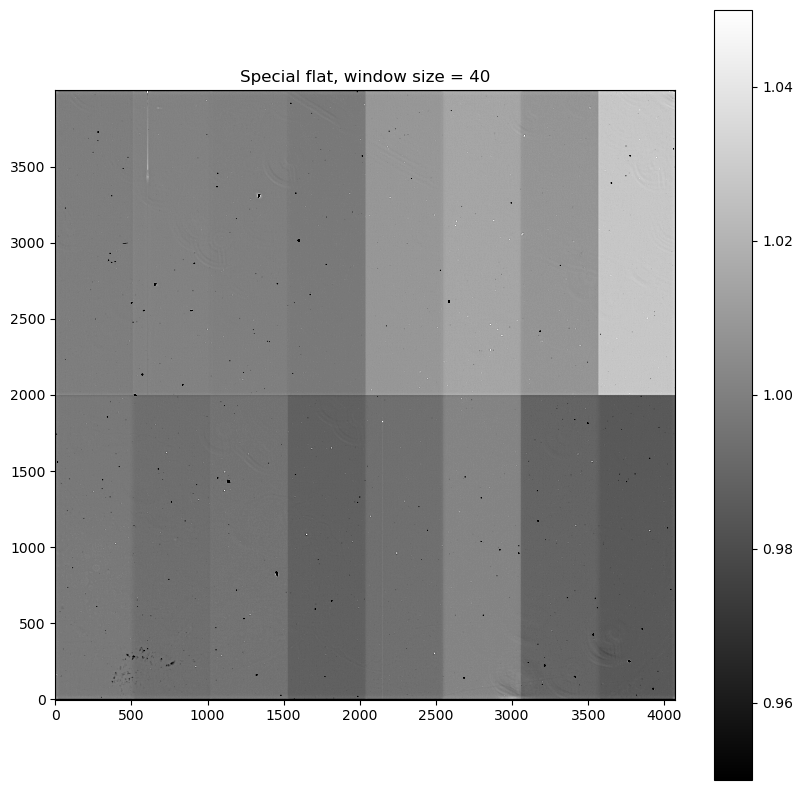

In [31]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(special_array,cmap="gray",vmin=0.95,vmax=1.05,origin='lower')#,norm=LogNorm())
ax.set_title('Special flat, window size = {0}'.format(window_size))
plt.colorbar(im,ax=ax)
plt.savefig(os.path.join(outdir,'special_flat_{0}_{1}_ws_{2}.png'.format(flat_selected,filter_,window_size)))

# Save normal and special flat in fits files 

In [32]:
filename_out = 'flat_{0}_{1}.fits'.format(flat_selected,filter_)
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()

for key,value in md.items():
    hdr[str(key)] = value


# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(flat_array)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)



>>>>  output filename flat_2023011600015_empty_1.fits


In [33]:
filename_out = 'special_flat_{0}_{1}_ws_{2}.fits'.format(flat_selected,filter_,window_size)
fullfilename_out = os.path.join(outdir,filename_out)

print(f">>>>  output filename {filename_out}")

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(special_array)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)



>>>>  output filename special_flat_2023011600015_empty_1_ws_40.fits
